# Fine-Tuning OpenCLIP

This notebook is an implementation of [OpenCLIP](https://github.com/mlfoundations/open_clip) finetuning with [WiSE-FT](https://github.com/mlfoundations/wise-ft) method for the Ottoman Nature in Travelogues [(ONiT) project](https://onit.oeaw.ac.at/).

Two fine-tuning variants are experimented with:
1) fine-tuning of a linear classifier on top of frozen OpenCLIP representation network (linear probing);
2) end-to-end fine-tuning of OpenCLIP with a linear classifier on top (contrastive learning).

More detailed documentation & final code follows. WORK IN PROGRESS...

In [1]:
# Import packages
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import torch.distributed as dist
from PIL import Image
import pandas as pd
import os
import numpy as np
import math
import open_clip
from tqdm.notebook import tqdm
import time
from torch.utils.tensorboard import SummaryWriter
import random

## Load pre-trained model

In [2]:
# List available models
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commo

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # If using 1 GPU then use mixed precision training
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion400m_e31', device=device, jit=False) #Must set jit=False for training

## Image preprocessing parameters

In [4]:
# Import image preprocessing packages
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

# Define custom image preprocessing parameters
BATCH_SIZE = 128
IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
train_val_split_ratio = 0.8 # 80/20 ratio for training/validation data

# Define pad function (add black borders to keep aspect ratio)
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')

# Define custom preprocess function
preprocess = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Define preprocess for preview
preprocess_preview = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    #transforms.Normalize(MEAN, STD)
])

# Define preprocess for thumbnail
preprocess_thumb = transforms.Compose([
    SquarePad(),
    transforms.Resize((50, 50)),
])

## Text preprocessing: Load tokenizer

In [5]:
# Import text preprocessing packages
from open_clip import tokenizer

tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [6]:
tokenizer

<function open_clip.tokenizer.tokenize(texts: Union[str, List[str]], context_length: int = 77) -> torch.LongTensor>

## Load data

In [7]:
# Data paths
img_dir = 'images'
data_subset_csv = '~/storage/ONiT-CLIP/data/nature_subset_cleaned4FT_GT.csv'

In [8]:
# Load CSV file with filenames, captions, and image paths
data_full = pd.read_csv(data_subset_csv, sep='|', na_filter=False)
data_full = data_full.dropna()

# Load the image paths, filenames, and captions from a CSV file into lists
image_filenames = data_full["filename"].tolist()
image_captions = data_full["annotation"].tolist()
labels = data_full["label"].tolist()
labels_num = []

for label in data_full["class number"]:
    if isinstance(label, int):
        labels_num.append('[', label, ']')
    elif isinstance(label, str):
        # Handle comma-separated values within a string
        label_list = [int(x.strip()) for x in label.split(',') if x.strip().isdigit()]
        labels_num.append(label_list)

from sklearn import preprocessing
mlb = preprocessing.MultiLabelBinarizer()
#mlb.fit(['1', '2', '3', '4'])
labels_num = mlb.fit_transform(labels_num)
labels_num = labels_num[:, :-1]
#print(labels_num)
print(labels_num.shape)
print(len(labels))

(22716, 4)
22716


In [9]:
# Load image paths
image_paths = []
for image_filename in image_filenames:
    img_path = os.path.join(img_dir, image_filename)
    image_paths.append(img_path)

In [10]:
data_full

,filename,annotation,path,index,label,class number
0,embhab_hab_li77441_pic142.jpg,"Image depicting hourglass, animal",images/embhab_hab_li77441_pic142.jpg,2,'animals',1
1,IIHIM_-739492654.jpg,Image depicting insect,images/IIHIM_-739492654.jpg,3,'animals',1
2,embepu_su1724_pic10005.jpg,"Image depicting perfection, soul, Divotione, R...",images/embepu_su1724_pic10005.jpg,4,'animals',1
3,IIHIM_-1674073675.jpg,"Image depicting hunter, huntress, conversation...",images/IIHIM_-1674073675.jpg,6,'animals',1
4,IIHIM_-1186622624.jpg,"Image depicting Mostri, animal, monster, shape...",images/IIHIM_-1186622624.jpg,7,'animals',1
...,...,...,...,...,...,...
22711,IIHIM_RIJKS_-808802799.jpg,"Image depicting globe, tool, writing tool",images/IIHIM_RIJKS_-808802799.jpg,34717,'maps',4
22712,IIHIM_RIJKS_642351449.jpg,Image depicting city,images/IIHIM_RIJKS_642351449.jpg,34718,'maps',4
22713,IIHIM_RIJKS_1638784261.jpg,"Image depicting city, battle, fortress",images/IIHIM_RIJKS_1638784261.jpg,34721,'maps',4
22714,128c4_172v_173r.jpg,"Image depicting latitude, longitude, continent",images/128c4_172v_173r.jpg,34722,'maps',4


## Define dataset class and data loader

In [11]:
# Define dataset classes
class IconclassDataset(Dataset):
    def __init__(self, image_paths, image_captions, transform=None):
        self.image_paths = image_paths
        self.image_captions = image_captions
        self.preprocess = preprocess
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        caption = self.image_captions[idx]
        image_path = self.image_paths[idx]
        try:
            with open(image_path, 'rb') as f:
                image = Image.open(f).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image file {image_path} not found. Skipping...")
            pass
        image_prep = preprocess(image)
        caption_prep = tokenizer(caption)[0]
        return image_prep, caption_prep

class TestDataset(Dataset):
    def __init__(self, image_paths, image_captions, labels, labels_num, transform=None):
        self.image_paths = image_paths
        self.image_captions = image_captions
        self.labels = labels
        self.labels_num = labels_num
        self.preprocess = preprocess
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        caption = self.image_captions[idx]
        label = self.labels[idx]
        label_num = self.labels_num[idx]
        image_path = self.image_paths[idx]
        try:
            with open(image_path, 'rb') as f:
                image = Image.open(f).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image file {image_path} not found. Skipping...")
            pass
        image_prep = preprocess(image)
        caption_prep = tokenizer(caption)[0]
        return image_prep, caption_prep, label, label_num

In [12]:
# Define your data loader
dataset = IconclassDataset(image_paths, image_captions)
labels_dataset = TestDataset(image_paths, image_captions, labels, labels_num)
data_loader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

## Split into training and validation data sets
# Total samples length
total_samples = len(image_paths)

# Calculate the sizes of the training and validation sets
train_size = int(train_val_split_ratio * total_samples)
val_size = int((total_samples - train_size)/2)
test_size = int((total_samples - train_size)/2)

# Set a fixed random seed
random_seed = 42
# Use random_split to create training and validation datasets
train_dataset, val_dataset, test_dataset = random_split(labels_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed))
## For fine-tuning of CLIP use dataset (loads image-caption pairs);
## for get_features and classification layer training use labels_dataset (loads images, captions & labels)

# Define your data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total dataset size: {len(dataset)}')
print(f'Training dataset size: {train_size}')
print(f'Validation dataset size: {val_size}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Batch size: {BATCH_SIZE}')
print(f'Number of batches training data loader: {len(train_loader)}')
print(f'Number of batches validation data loader: {len(val_loader)}')

Total dataset size: 22716
Training dataset size: 18172
Validation dataset size: 2272
Test dataset size: 2272
Batch size: 128
Number of batches training data loader: 142
Number of batches validation data loader: 18


## Preview data

In [13]:
import matplotlib.pyplot as plt
import textwrap

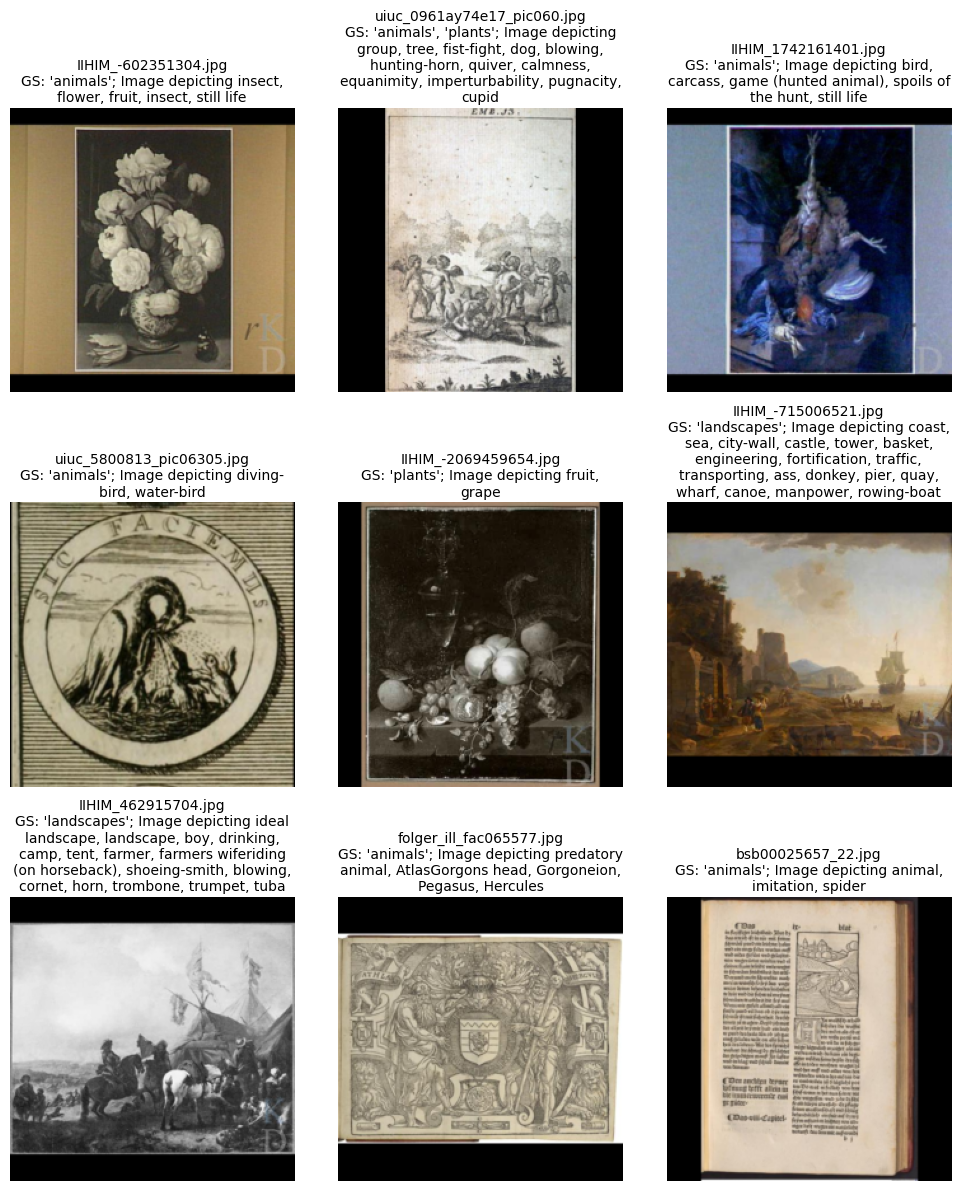

In [17]:
# Define the number of rows and columns in the preview table
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

# Shuffle the indices of the images and captions from the full dataset
indices = list(range(len(image_paths)))
random.shuffle(indices)

# Load the images and captions for the preview and results tables
images = []
indx = []
for i, index in enumerate(indices[:num_images]):
    image = Image.open(image_paths[index]).convert("RGB")
    #print('Image path: ', image_paths[index])
    images.append(image)
    indx.append(index)
    if i == num_images - 1:
        break

# Create lists of captions, filenames, groundtruth, and classnumber of the set of images
captions = [image_captions[index] for index in indices[:num_images]]
filenames = [image_filenames[index] for index in indices[:num_images]]
groundtruth = [labels[index] for index in indices[:num_images]]
#classnumber = [class_number[index] for index in indices[:num_images]]

# Preprocess the images with the torchvision transform
preprocessed_images = torch.stack([preprocess_preview(image) for image in images])

# Create the preview table
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(preprocessed_images[i].permute(1, 2, 0))
    ax.axis("off")
    
    # Add the label as the title
    longtitle = '\n'.join(textwrap.wrap('GS: ' + groundtruth[i] + '; ' + captions[i], width=40))
    filename = filenames[i]
    title = ax.set_title(filename + "\n" + longtitle, fontsize=10, clip_on=True, wrap=True)
    title.set_position([.5, .9])

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5)

# Show the preview table
plt.tight_layout()
plt.show()

## Fine-tuning parameters

In [21]:
# Finetuning parameters
LR=5e-5 
EPOCHS = 20
num_batches = len(train_loader)
weight_decay=0.2
num_classes = 4

freeze_encoder = False # Set to False for end-to-end fine-tuning; Set to True to fine-tune the linear classifier only

SAVE_MODEL = 'CLIP-finetune/models/' # Specify path to save fine-tuned model
CACHE_DIR = os.path.join(SAVE_MODEL, "cache/") # Directory for caching features and encoder

# TensorBoard writer
writer = SummaryWriter(log_dir=SAVE_MODEL)

In [22]:
for param in model.parameters():
    param.requires_grad = True # Fine-tune full model without frozen parameters
    
# Freezing selected layers
for name, param in model.named_parameters():
    if 'resblocks.11' in name:
        param.requires_grad = True # Set to true to train selected model parameters
    elif 'resblocks.10' in name:
        param.requires_grad = True # Set to true to train selected model parameters
    else:
        param.requires_grad = False # Freeze all other parameters (set to false)

In [23]:
# Print parameter settings
for name, param in model.named_parameters():
    print('Name: ', name, '- Requires_Grad: ', param.requires_grad)

Name:  positional_embedding - Requires_Grad:  False
Name:  text_projection - Requires_Grad:  False
Name:  logit_scale - Requires_Grad:  False
Name:  visual.class_embedding - Requires_Grad:  False
Name:  visual.positional_embedding - Requires_Grad:  False
Name:  visual.proj - Requires_Grad:  False
Name:  visual.conv1.weight - Requires_Grad:  False
Name:  visual.ln_pre.weight - Requires_Grad:  False
Name:  visual.ln_pre.bias - Requires_Grad:  False
Name:  visual.transformer.resblocks.0.ln_1.weight - Requires_Grad:  False
Name:  visual.transformer.resblocks.0.ln_1.bias - Requires_Grad:  False
Name:  visual.transformer.resblocks.0.attn.in_proj_weight - Requires_Grad:  False
Name:  visual.transformer.resblocks.0.attn.in_proj_bias - Requires_Grad:  False
Name:  visual.transformer.resblocks.0.attn.out_proj.weight - Requires_Grad:  False
Name:  visual.transformer.resblocks.0.attn.out_proj.bias - Requires_Grad:  False
Name:  visual.transformer.resblocks.0.ln_2.weight - Requires_Grad:  False
Nam

In [24]:
# Define optimizer and loss function
params = [p for p in model.parameters() if p.requires_grad] #filters out only the parameters that require gradients, and these are the parameters that the optimizer will update during the training process.
optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss()

In [25]:
# Access the intermediate hidden layer
hidden_layer = model.visual.transformer.resblocks[-1].mlp.c_proj

# Display the hidden layer's configuration
print(hidden_layer)

# Load computed zeroshot weights
zeroshot_weights = torch.load(os.path.join(SAVE_MODEL, f"zeroshot_weights.pt"))
output_size, input_size = zeroshot_weights.shape
print(zeroshot_weights.shape)

Linear(in_features=3072, out_features=768, bias=True)
torch.Size([1000, 512])


In [26]:
class FTModel(nn.Module):
    def __init__(self, model):
        super(FTModel, self).__init__()
        self.model = model
        #self.fc = nn.Linear(hidden_layer.out_features, num_classes)

    def forward(self, images, captions):
        image_outputs = self.model.encode_image(images)
        caption_outputs = self.model.encode_text(captions)
        
        #print('Image outputs shape: ', image_outputs.shape)
        #print('Caption outputs shape: ', caption_outputs.shape)
        return image_outputs, caption_outputs

finetune_model = FTModel(model)

print(finetune_model)

FTModel(
  (model): CLIP(
    (visual): VisionTransformer(
      (patchnorm_pre_ln): Identity()
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-11): 12 x ResidualAttentionBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ls_2): Id

In [27]:
devices = list(range(torch.cuda.device_count()))

## DOES NOT WORK
# Initialize PyTorch distributed backend (if not already initialized)
#if not dist.is_initialized():
#    dist.init_process_group(backend='nccl')
#model = nn.parallel.DistributedDataParallel(model)

## USE THIS TO PARALLELIZE if needed
#model = model.cuda() # Push model to (multiple) GPUs
#model = torch.nn.DataParallel(model, device_ids=devices) # For parallelization on multiple GPUs (wrapper)

print('Using devices', devices)
print('Torch CUDA device count: ', torch.cuda.device_count())

print(model.train())

Using devices [0]
Torch CUDA device count:  1
CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
     

# End-to-End Fine-Tuning OpenCLIP

In [ ]:
# Automatic mixed precision fine-tuning end-to-end
scaler = GradScaler()

print('Fine-tuning end-to-end')
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training Dataset Size: {train_size}")
model = finetune_model
train_loader = train_loader
val_loader = val_loader

## TRAINING ##
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    # Create the progress bar
    data_loader_iter = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}", leave=True, dynamic_ncols=False)
    
    for batch_idx, (image_prep, caption_prep) in enumerate(data_loader_iter):
        start_time = time.time()
        
        optimizer.zero_grad()

        #caption_prep = caption_prep.unsqueeze(2).unsqueeze(3)
        
        #print(f'Batch {batch_idx +1}:')
        #print(f'Images shape: {image_prep.shape}')
        #print(f'Captions shape: {caption_prep.shape}')
        
        images = image_prep.to(device)
        captions = caption_prep.to(device)
        data_time = time.time() - start_time

        with autocast():
            outputs = model(images, captions)
            #print('Outputs: ', outputs)
            logits_per_image = outputs[0]
            logits_per_caption = outputs[1]
            #print('Logits per image: ', logits_per_image.shape)
            #print('Logits per caption: ', logits_per_caption.shape)
            
            ### Computation of ground_truth and contrastive loss taken from https://github.com/openai/CLIP/issues/83
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            loss = (loss_fn(logits_per_image,ground_truth) + loss_fn(logits_per_caption,ground_truth))/2 # Compute contrastive loss

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        torch.nn.utils.clip_grad_norm_(params, 1.0)
        
        running_loss += loss.item()
        batch_time = time.time() - start_time

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            writer.add_scalar("Training Loss (over the batches)", loss.item(), epoch * len(train_loader) + batch_idx)
            #print("Batch Training Loss", loss.item())
            #print(f"Epoch: {epoch + 1}/{EPOCHS}, Batch: {batch_idx + 1}/{len(train_loader)}")

        if i % 100 == 0:
            percent_complete = 100 * i / len(data_loader)
            print(
                f"Loss: {loss.item():.6f}\tData (t) {data_time:.3f}\tBatch (t) {batch_time:.3f}", flush=True
            )
    running_loss /= len(train_loader)
    # train_accuracy = correct / total

    writer.add_scalar("Training Loss (over the epochs)", running_loss, epoch)
    # writer.add_scalar("Training Accuracy (over the epochs)", train_accuracy, epoch)
    print("\nTraining Loss", running_loss)
    # print("\nTraining Accuracy: ", train_accuracy)

    ## Validation ##
    model.eval()
    val_loss = 0.0

    val_loader_iter = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{EPOCHS}", leave=True, dynamic_ncols=False)

    with torch.no_grad():
        for batch_idx, (image_prep, caption_prep) in enumerate(val_loader_iter):
            images = image_prep.to(device)
            captions = caption_prep.to(device)
            val_time = time.time() - start_time

            outputs = model(images, captions)
            logits_per_image = outputs[0]
            logits_per_caption = outputs[1]

            ### Computation of ground_truth and contrastive loss taken from https://github.com/openai/CLIP/issues/83
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            loss = (loss_fn(logits_per_image,ground_truth) + loss_fn(logits_per_caption,ground_truth))/2 # Compute contrastive loss
            val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(val_loader):
                writer.add_scalar("Validation Loss (over the batches)", loss.item(), epoch * len(val_loader) + batch_idx)

    val_loss /= len(val_loader)
    # val_accuracy = correct / total
    
    writer.add_scalar("Validation Loss (over the epochs)", val_loss, epoch)
    # writer.add_scalar("Validation Accuracy (over the epochs)", val_accuracy, epoch)
    print("\nValidation Loss", val_loss)
    # print("\nValidation Accuracy: ", val_accuracy)

In [ ]:
#%load_ext tensorboard

#%tensorboard --logdir=SAVE_MODEL

In [ ]:
# Save the fine-tuned model

os.makedirs(SAVE_MODEL, exist_ok=True)

if freeze_encoder == True:
    finetuned_model = ImageClassifier(image_encoder, model)
    print('Saving model to ', SAVE_MODEL, f"fine_tuned_clip_linear_checkpoint_{epoch+1}.pt")
    torch.save(finetuned_model, os.path.join(SAVE_MODEL, f"fine_tuned_clip_linear_checkpoint_{epoch+1}.pt"))
    
else:
    print('Saving model to ', SAVE_MODEL, f"fine_tuned_clip_full_checkpoint_{epoch+1}.pt")
    torch.save(model, os.path.join(SAVE_MODEL, f"fine_tuned_clip_full_checkpoint_{epoch+1}.pt"))


## Interpolate fine-tuned and zero-shot weights (WiSE-FT)

In [ ]:
# interpolation coefficient
alpha = 0.5

'Interpolation coefficient for ensembling. '
'Users should specify N-1 values, where N is the number of '
'models being ensembled. The specified numbers should sum to '
'less than 1. Note that the order of these values matter, and '
'should be the same as the order of the classifiers being ensembled.'

In [ ]:
# Load fine-tuned and zero-shot model checkpoints

if freeze_encoder == True:
    print('Load fine-tuned linear classifier checkpoint')
    finetuned_checkpoint = os.path.join(SAVE_MODEL, f"fine_tuned_clip_linear_checkpoint_{epoch+1}.pt")
    zeroshot = zeroshot_custom

else:
    print('Load fine-tuned full model checkpoint')
    finetuned_checkpoint = os.path.join(SAVE_MODEL, f"fine_tuned_clip_full_checkpoint_{epoch+1}.pt")
    zeroshot = FTModel(open_clip.create_model('ViT-B-32', pretrained='laion400m_e31', device=device, jit=False))

finetuned = torch.load(finetuned_checkpoint)

In [ ]:
print(finetuned)

In [ ]:
print(len(zeroshot.state_dict().keys()))
print(len(finetuned.state_dict().keys()))

In [ ]:
# Compute interpolation
theta_0 = zeroshot.state_dict()
theta_1 = finetuned.state_dict()

# make sure checkpoints are compatible
assert set(theta_0.keys()) == set(theta_1.keys())

# interpolate between checkpoints with mixing coefficient alpha
theta = {
    key: (1-alpha) * theta_0[key] + alpha * theta_1[key]
    for key in theta_0.keys()
}

# update the model acccording to the new weights
finetuned.load_state_dict(theta)


In [ ]:
# save model
if freeze_encoder == True:
    print('Saving interpolated model to ', SAVE_MODEL, f'wise_ft_linear_alpha={alpha:.3f}.pt')
    torch.save(finetuned, os.path.join(SAVE_MODEL, f'wise_ft_linear_alpha={alpha:.3f}.pt'))

else:
    print('Saving interpolated model to ', SAVE_MODEL, f'wise_ft_full_alpha={alpha:.3f}.pt')
    torch.save(finetuned, os.path.join(SAVE_MODEL, f'wise_ft_full_alpha={alpha:.3f}.pt'))

## Evaluation

In [ ]:
# TODO: evaluate
#evaluate(finetuned, args)

## Get Features

In [28]:
# Load model

finetuned_checkpoint = os.path.join(SAVE_MODEL, "finetune_full_all-resblocks10-11_frozen_20epochs/wise_ft_full_alpha=0.500.pt")

model = torch.load(finetuned_checkpoint)

In [49]:
## TODO
# Get features with loaded image encoder of original model as input for fine-tuning the linear classifier

# Get Features function
def get_features(test_dataset):
    image_features = []
    text_features = []
    labels_num = []
    labels = []

    with torch.no_grad():
        for image_prep, caption_prep, label, label_num in tqdm(test_loader):
            #print('Images: ', image_prep.shape)
            #print('Captions: ', caption_prep.shape)
            #print('Labels: ', len(label_num))
            imfeat = model.model.encode_image(image_prep.to(device))
            capfeat = model.model.encode_text(caption_prep.to(device))
            
            image_features.append(imfeat)
            text_features.append(capfeat)
            labels_num.append(label_num)
            labels.append(label)

    labels = [item for batch in labels for item in batch]

    return torch.cat(image_features).cpu().numpy(), torch.cat(text_features).cpu().numpy(), torch.cat(labels_num).cpu().numpy(), labels

# Calculate image features
image_features, text_features, labels_num, labels = get_features(test_dataset)

  0%|          | 0/18 [00:00<?, ?it/s]

In [42]:
print(image_features.shape, text_features.shape, labels_num.shape, len(labels))

(2272, 512) (2272, 512) (2272, 4) 2272


## Classification with cosine similarity

First tests done with the approach described in the "How to interact with OpenCLIP notebook" -- Conclusion: No conclusive results without additional linear classifier for multi-label classification problem.

In [43]:
# Define labels for classification
labels_classification = ['animals',
                        'plants',
                        'landscapes',
                        'maps']

In [44]:
# Create prompts and tokenize them
class_descriptions = [f"an image of {label}" for label in labels_classification]
class_tokens = tokenizer(class_descriptions)

gt = [f"an image of {label}" for label in labels]
gt_tokens = tokenizer(gt)

In [53]:
# Class prediction for multi-class classification of full dataset

with torch.no_grad():
    class_tokens = class_tokens.cuda()
    class_features = model.model.encode_text(class_tokens).float()
    class_features /= class_features.norm(dim=-1, keepdim=True)

image_features = torch.tensor(image_features)
image_features = image_features.clone().detach().cuda()
class_probs = (0.01 * image_features @ class_features.T).sigmoid()

# Set a threshold (you can experiment with different values)
threshold = 0.5

# Convert probabilities to binary predictions based on the threshold
predictions = (class_probs > threshold).float()

#class_probs = (100.0 * image_features @ class_features.T).softmax(dim=-1) # softmax is for single label classification!
top_probs, top_labels = predictions.cpu().topk(4, dim=-1)

Class 1:
  Precision: 0.4722711267605634
  Recall: 1.0
  F1 Score: 0.6415545590433482
  Accuracy: 0.4722711267605634
  Confusion Matrix:


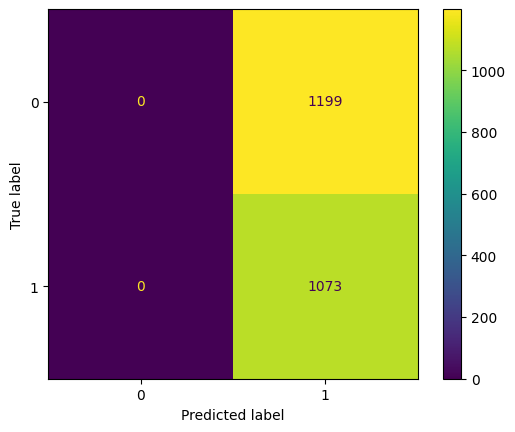


Class 2:
  Precision: 0.2579225352112676
  Recall: 1.0
  F1 Score: 0.41007697690692796
  Accuracy: 0.2579225352112676
  Confusion Matrix:


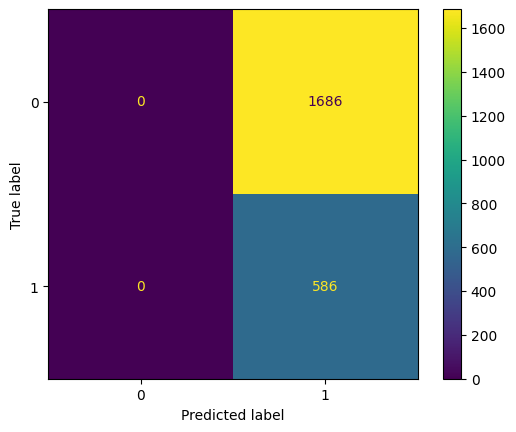


Class 3:
  Precision: 0.3732394366197183
  Recall: 1.0
  F1 Score: 0.5435897435897437
  Accuracy: 0.3732394366197183
  Confusion Matrix:


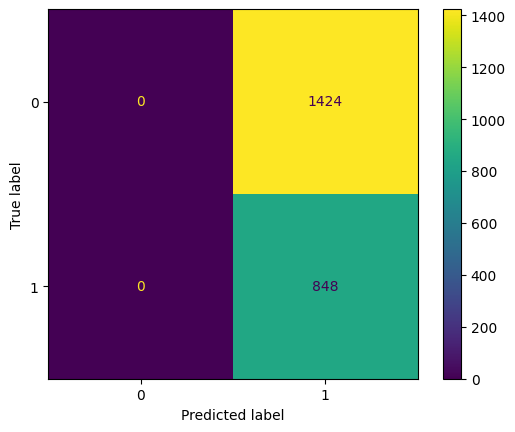


Class 4:
  Precision: 0.05413732394366197
  Recall: 1.0
  F1 Score: 0.10271398747390396
  Accuracy: 0.05413732394366197
  Confusion Matrix:


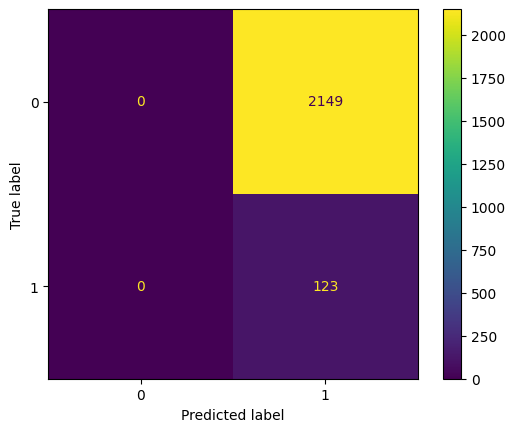

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
import numpy as np

true_labels =  labels_num
predictions =  predictions.cpu()

# Assuming true_labels is the ground truth and predictions are the model predictions
# You may need to adjust the axis parameter based on your data format
# For example, if axis=0, it means that each column represents a class
# If axis=1, it means that each row represents a class

# Precision, Recall, F1 Score, and Accuracy for each class
precision_per_class = precision_score(true_labels, predictions, average=None)
recall_per_class = recall_score(true_labels, predictions, average=None)
f1_per_class = f1_score(true_labels, predictions, average=None)

# Multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(true_labels, predictions)

# Calculate accuracy per class
accuracy_per_class = []
for i in range(len(confusion_matrices)):
    tn, fp, fn, tp = confusion_matrices[i].ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0
    accuracy_per_class.append(accuracy)

# Display the results for each class
for i in range(len(precision_per_class)):
    print(f"Class {i + 1}:")
    print(f"  Precision: {precision_per_class[i]}")
    print(f"  Recall: {recall_per_class[i]}")
    print(f"  F1 Score: {f1_per_class[i]}")
    print(f"  Accuracy: {accuracy_per_class[i]}")
    print(f"  Confusion Matrix:")
    
    # Plot confusion matrix
    fig, ax = plt.subplots()
    classes = [f"Class {j}" for j in range(confusion_matrices.shape[1])]
    disp = ConfusionMatrixDisplay(confusion_matrices[i])
    disp.plot(cmap='viridis', ax=ax)
    plt.show()

    print()

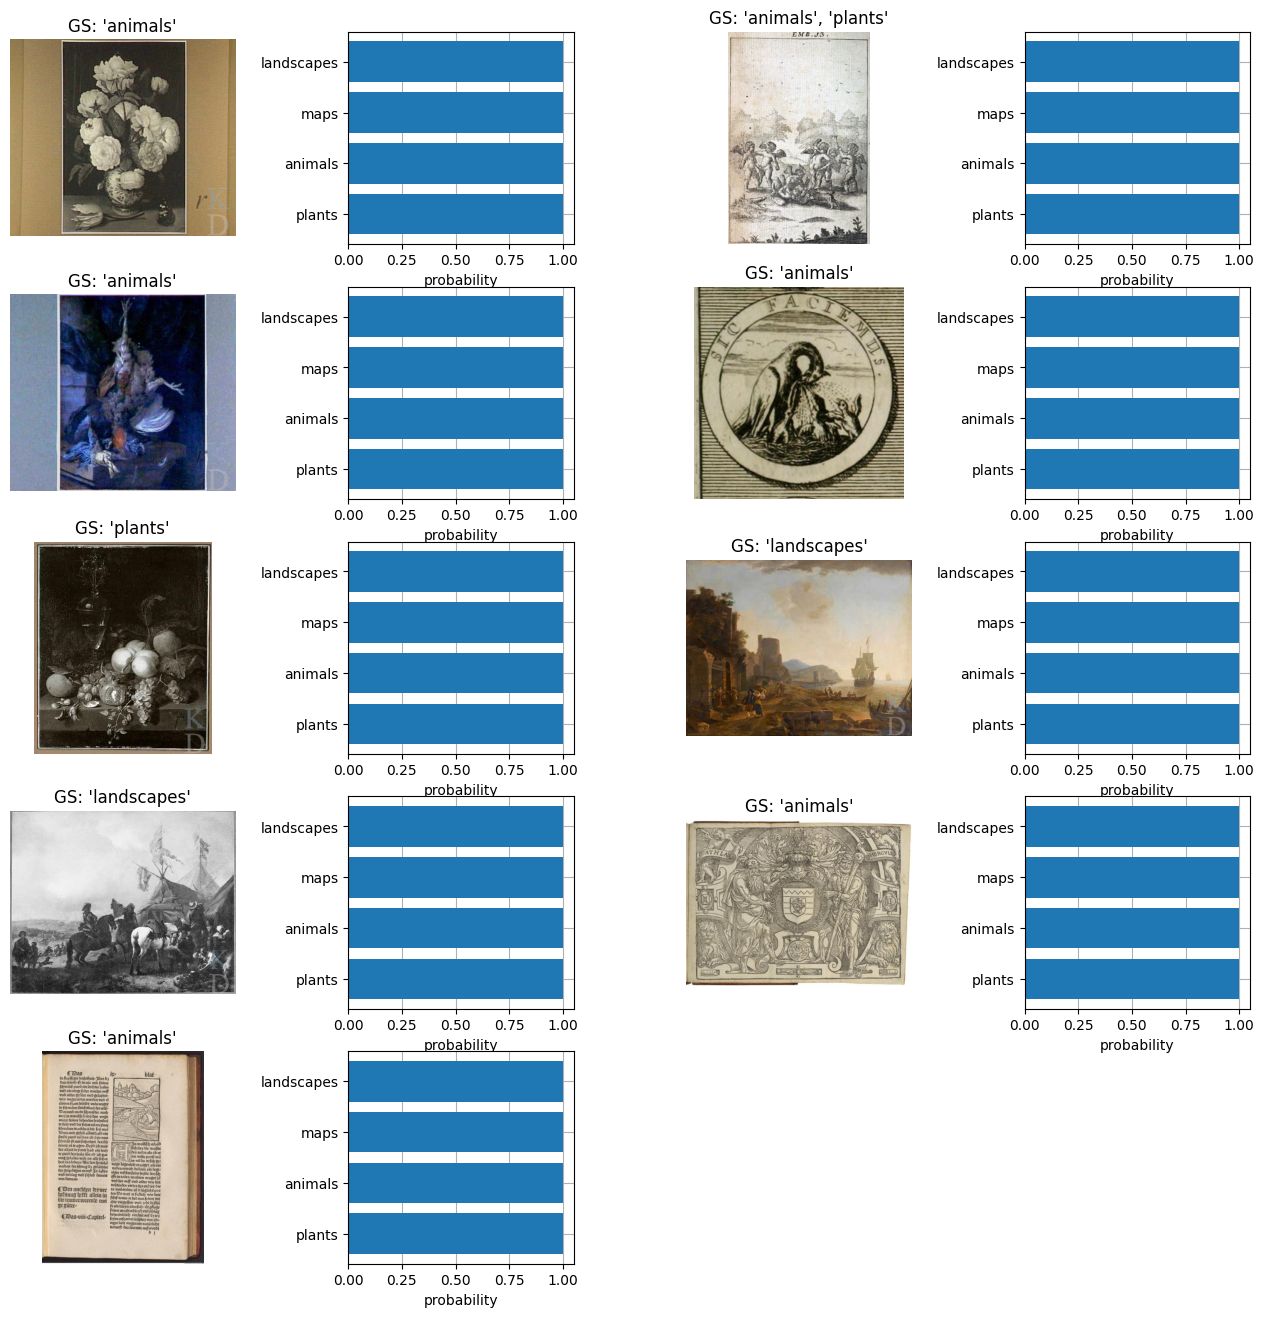

In [47]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(images):
    plt.subplot(5, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")
    # Add ground truth label
    plt.title("GS: " + groundtruth[i])
    #plt.title(groundtruth[i])

    plt.subplot(5, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    #print("Top Probs: ", top_probs)
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    # Add predicted labels
    plt.yticks(y, [labels_classification[index] for index in top_labels[i].numpy()], fontsize=10, clip_on=True, wrap=True)
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

## Classification with k-NN (k-Nearest Neighbors) on the embedded features

In [50]:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Concatenate the text and image features
features_combined = np.concatenate([image_features, text_features], axis=1)
print('Features ', features_combined.shape)
print('Labels ', labels_num.shape)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(features_combined, labels_num, test_size=0.2, random_state=42)
#print('Splitting data sets...')
#print('X_train: ', X_train.shape)
#print('X_test: ', X_test.shape)
#print('y_train: ', y_train.shape)
#print('y_test: ', y_test.shape)

# Initialize the k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier.fit(features_combined, labels_num)

# Make predictions on the test set
y_pred = knn_classifier.predict(features_combined)

pred_tensor = torch.tensor(y_pred)

top_probs, top_labels = pred_tensor.cpu().topk(4, dim=-1)

Features  (2272, 1024)
Labels  (2272, 4)


Class 1:
  Precision: 0.9128440366972477
  Recall: 0.9273066169617894
  F1 Score: 0.9200184928340268
  Accuracy: 0.9238556338028169
  Confusion Matrix:


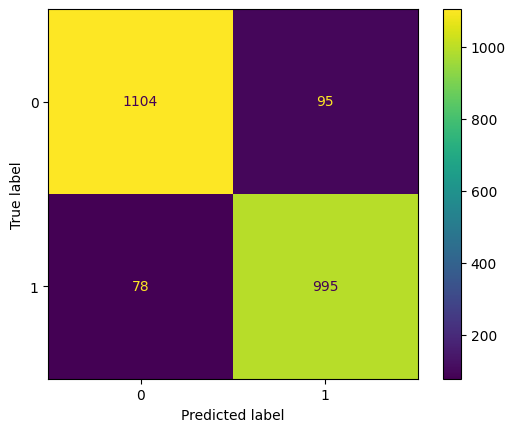


Class 2:
  Precision: 0.9513618677042801
  Recall: 0.8344709897610921
  F1 Score: 0.8890909090909092
  Accuracy: 0.9463028169014085
  Confusion Matrix:


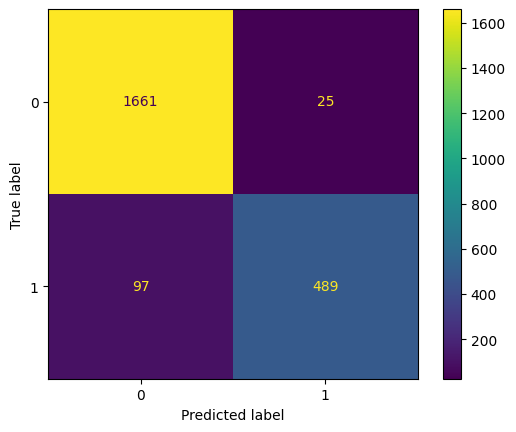


Class 3:
  Precision: 0.898989898989899
  Recall: 0.9445754716981132
  F1 Score: 0.9212190914318573
  Accuracy: 0.9397007042253521
  Confusion Matrix:


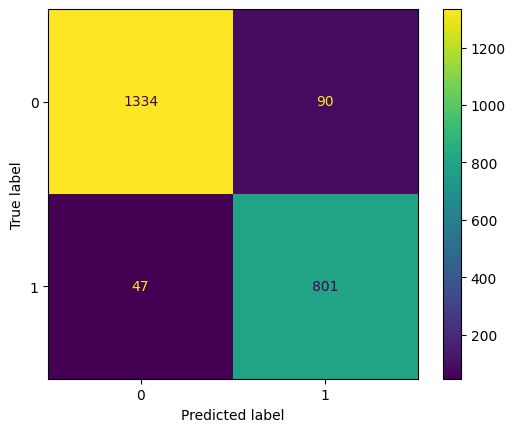


Class 4:
  Precision: 0.967032967032967
  Recall: 0.7154471544715447
  F1 Score: 0.8224299065420562
  Accuracy: 0.983274647887324
  Confusion Matrix:


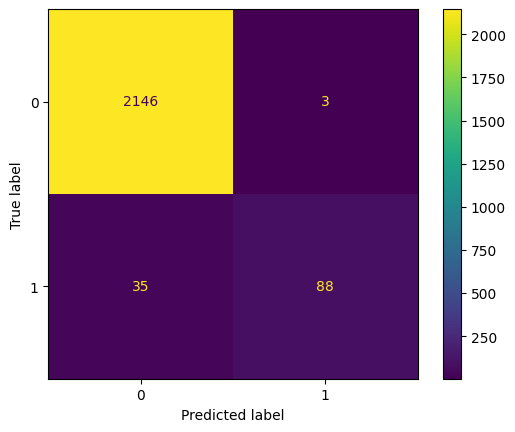

In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
import numpy as np

true_labels =  labels_num
predictions =  y_pred

# Assuming true_labels is the ground truth and predictions are the model predictions
# You may need to adjust the axis parameter based on your data format
# For example, if axis=0, it means that each column represents a class
# If axis=1, it means that each row represents a class

# Precision, Recall, F1 Score, and Accuracy for each class
precision_per_class = precision_score(true_labels, predictions, average=None)
recall_per_class = recall_score(true_labels, predictions, average=None)
f1_per_class = f1_score(true_labels, predictions, average=None)

# Multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(true_labels, predictions)

# Calculate accuracy per class
accuracy_per_class = []
for i in range(len(confusion_matrices)):
    tn, fp, fn, tp = confusion_matrices[i].ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0
    accuracy_per_class.append(accuracy)

# Display the results for each class
for i in range(len(precision_per_class)):
    print(f"Class {i + 1}:")
    print(f"  Precision: {precision_per_class[i]}")
    print(f"  Recall: {recall_per_class[i]}")
    print(f"  F1 Score: {f1_per_class[i]}")
    print(f"  Accuracy: {accuracy_per_class[i]}")
    print(f"  Confusion Matrix:")
    
    # Plot confusion matrix
    fig, ax = plt.subplots()
    classes = [f"Class {j}" for j in range(confusion_matrices.shape[1])]
    disp = ConfusionMatrixDisplay(confusion_matrices[i])
    disp.plot(cmap='viridis', ax=ax)
    plt.show()

    print()

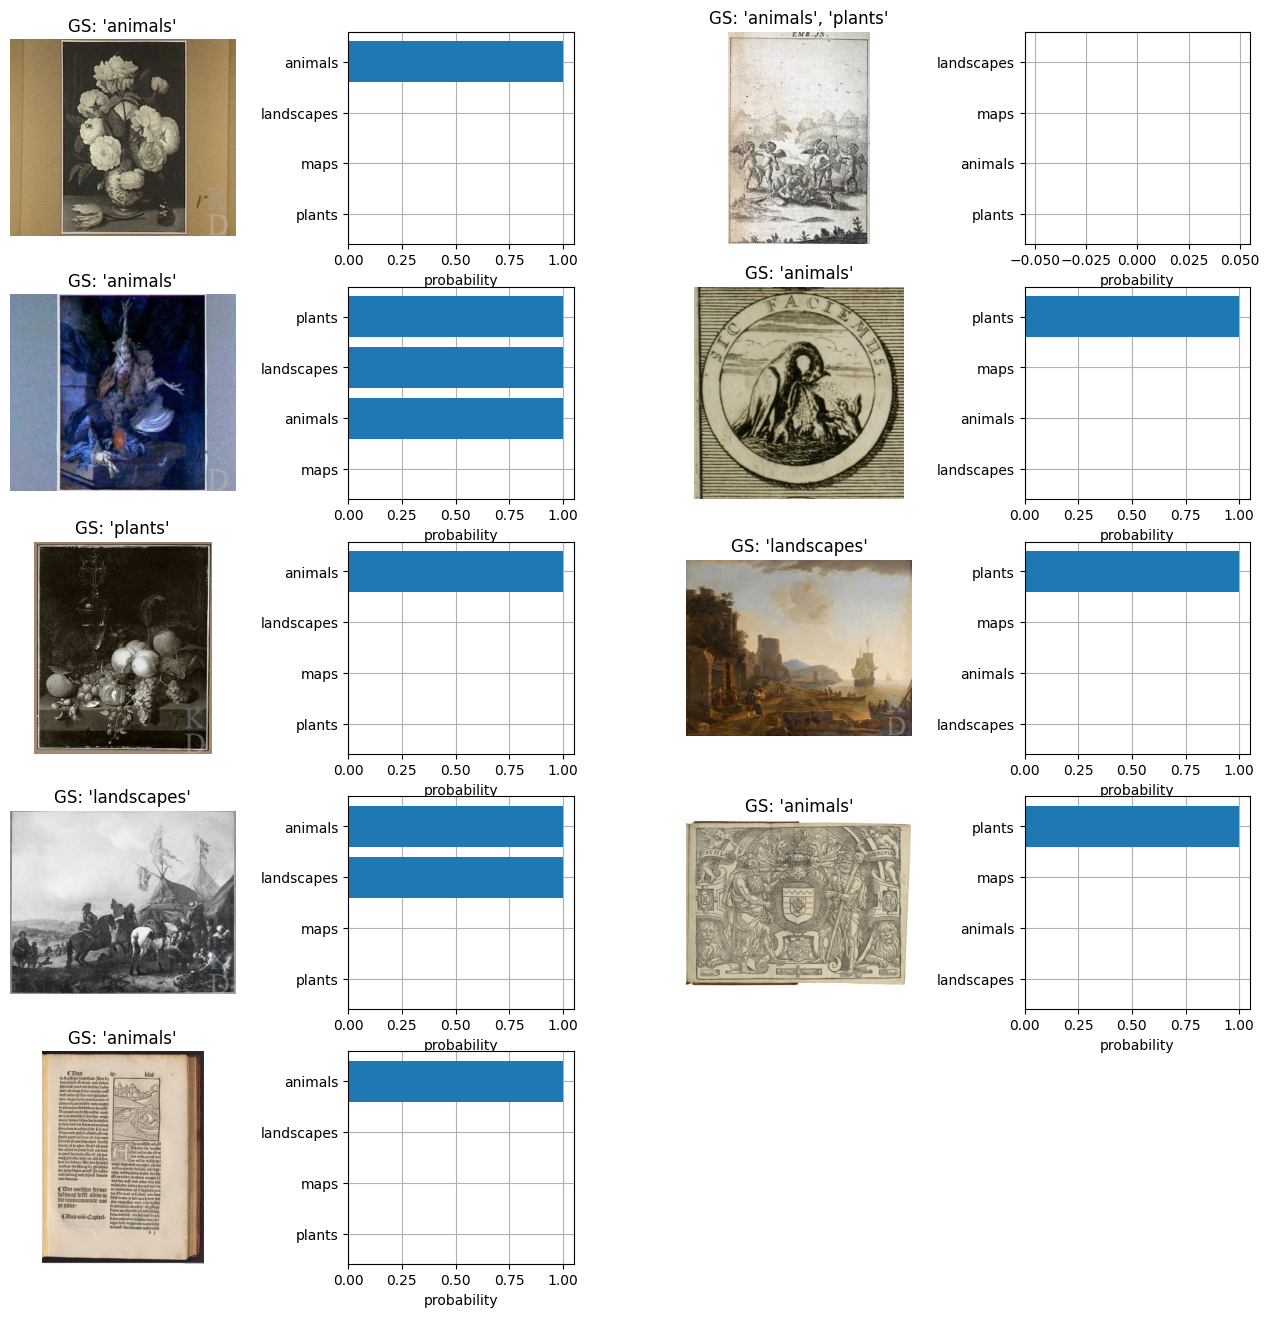

In [52]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(images):
    plt.subplot(5, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")
    # Add ground truth label
    plt.title("GS: " + groundtruth[i])
    #plt.title(groundtruth[i])

    plt.subplot(5, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    #print("Top Probs: ", top_probs)
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    # Add predicted labels
    plt.yticks(y, [labels_classification[index] for index in top_labels[i].numpy()], fontsize=10, clip_on=True, wrap=True)
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
# Compute cosine similarity
similarity = text_features @ image_features.T

similarity.shape